Download packages

In [51]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
from sklego.meta import OrdinalClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from itertools import cycle, islice
import matplotlib.patches as mpatches
from sklearn.cluster import HDBSCAN, OPTICS, DBSCAN
import scipy



In [52]:
random.seed(8)

Create new feature names to take the mean and std across epochs pr person

In [53]:
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]
print(mean_list)

['Delta_mean', 'Delta_N_mean', 'Theta_mean', 'Theta_N_mean', 'Alpha_mean', 'Alpha_N_mean', 'Beta_mean', 'Beta_N_mean', 'Gamma_mean', 'Gamma_N_mean', 'SE_mean', 'MSF_mean', 'Sef90_mean', 'Sef95_mean', 'PE_mean', 'wSMI_mean', 'Kolmogorov_mean', 'MeanRR_mean', 'StdRR_mean', 'MeanHR_mean', 'StdHR_mean', 'MinHR_mean', 'MaxHR_mean']


Concatenate data

In [54]:
import sklearn.preprocessing


path ='CSV_inspected_features_mean_chan/'
folder = os.fsencode(path)
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]


patient_numbers = []
r_data = []
m_data = []
f_data = []

all_data = []


for file in os.listdir(folder):
    filename = os.fsdecode(file)
    patient_numbers.append(filename[0:3])
    fname = path + filename
    data = pd.read_csv(fname)
    data.columns = renamed_markers_list
    sklearn.preprocessing.StandardScaler().set_output(transform='pandas') 
    data[m_list] = sklearn.preprocessing.StandardScaler().fit(data[m_list]).transform(data[m_list]) #standardising data within each patient
    
    all_data.append(data)




In [58]:
#fit pca across patients
data_for_pca = pd.concat(all_data)
pca = sklearn.decomposition.PCA(n_components=0.95)
components = pca.fit(data_for_pca[m_list]).components_


Inspecting optimal number of components to use

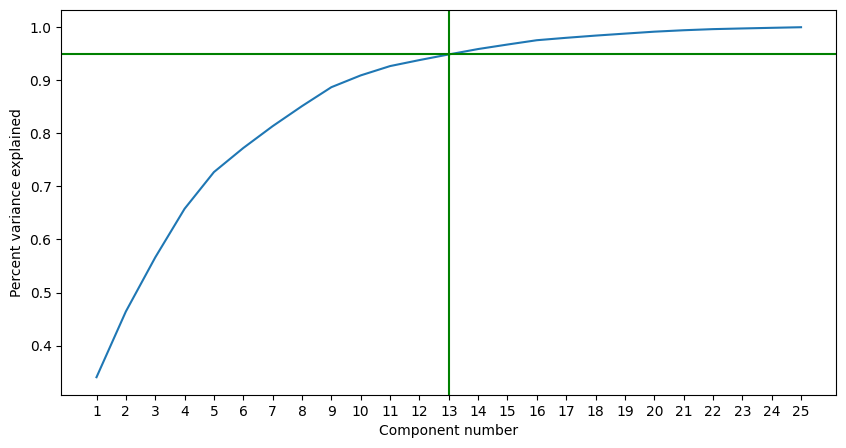

In [57]:
#done with all components
exp_var = pca.explained_variance_ratio_
plt.figure(figsize = (10, 5))
plt.plot(np.arange(1,26,1), exp_var.cumsum())
plt.xticks(np.arange(1,26,1))
plt.xlabel('Component number')
plt.ylabel('Percent variance explained')
plt.axvline(13, color='g')
plt.axhline(0.95, color='g')

Ignore irrelevant warnings

In [59]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

Forward feature selection for each person to find relevant features

In [125]:
import sklearn.model_selection
components_n = components.shape[0]
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

feat_scores = np.zeros((components_n, components_n))
best_comp = []
count = 1
all_scores = np.empty((components_n, len(all_data), components_n, 3))

improving = True

# Finding first optimal component to choose

for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    for j in range(components_n):
        skf = StratifiedKFold(n_splits=3)
        scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,j]).reshape(-1, 1), np.array(train_y), cv = skf, scoring='balanced_accuracy')
        score = scores.mean()
        feat_scores[0,j] += score
        all_scores[0, i, j, :] = scores

prev_score = np.max(feat_scores[0])
best_comp.append(np.argmax(feat_scores[0]))

# Looping through all combinations of features

while improving:
    for i in range(len(all_data)):
        train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
        train_X = all_data[i][m_list]
        train_X = pca.transform(train_X)
        train_X = pd.DataFrame(train_X)
        ord_clf = OrdinalClassifier(estimator=LogisticRegression())
        
        for j in range(components_n):
            if j not in best_comp:
                skf = StratifiedKFold(n_splits=3)
                scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,best_comp+[j]]), np.array(train_y), cv = skf, scoring='balanced_accuracy')
                score = scores.mean()
                feat_scores[count, j] += score
                all_scores[count, i,j,:] = scores
            
    #print(feat_scores)
    new_score = np.max(feat_scores[count])
    
    if new_score - prev_score < 0.1:
        improving = False
    else:
        prev_score = new_score
        best_comp.append(np.argmax(feat_scores[count]))
    count += 1

print('Final best components: ', best_comp)


Final best components:  [4, 2, 6, 0]


In [127]:
# Inspecting components
feature_dict = {}

for i in range(len(best_comp)):
    feature = best_comp[i]
    sort = np.argsort(abs(np.array(components[feature])))[::-1]
    feature_list = [(m_list[j], components[feature][j]) for j in sort[0:11]]

    for j in feature_list:
        if j[0] not in feature_dict:
            feature_dict[j[0]] = abs(j[1])
        else:
            feature_dict[j[0]] +=abs(j[1])

print(feature_dict)


{'Theta': 0.8793235344475795, 'Delta': 0.8631355798001306, 'Gamma': 0.4971320595718069, 'Beta': 0.5242221059249331, 'MeanHR': 0.4364269468088674, 'MeanRR': 0.39304723358935334, 'Alpha': 0.8419432318644566, 'MaxHR': 0.7518606651238742, 'Alpha_N': 0.7838281801992135, 'StdHR': 0.6925010084754429, 'MinHR': 0.3583208516800528, 'StdRR': 0.4971895787714632, 'Theta_N': 0.431115241610578, 'freq_slope_std': 0.33471270075242054, 'freq_slope_mean': 0.33358599762982843, 'PE': 0.43434091681376885, 'wSMI': 0.19788955585807108, 'Delta_N': 0.44678829328901914, 'Gamma_N': 0.3485143637954243, 'SE': 0.32426138829745565, 'Sef90': 0.3111853237653993, 'MSF': 0.2978411748278412, 'Sef95': 0.29751180486488216, 'Kolmogorov': 0.286171572571014, 'Beta_N': 0.2808932148712506}


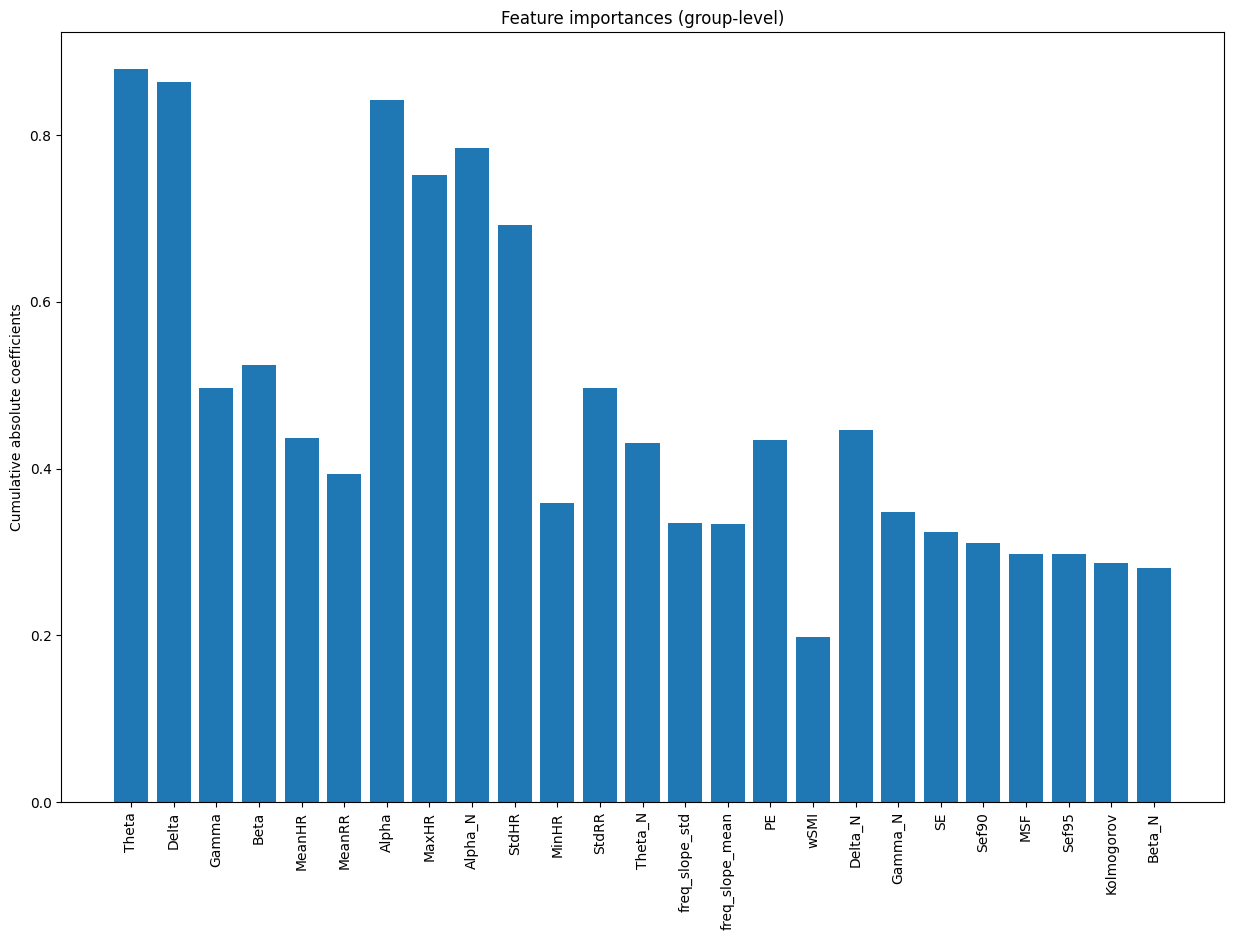

In [128]:
plt.figure(figsize=(15,10))
plt.bar(x=[i for i in range(0,len(feature_dict))], height=[i for i in feature_dict.values()])
plt.xticks(ticks=[i for i in range(0,len(feature_dict))], labels=[i for i in feature_dict.keys()], rotation=90)
plt.ylabel('Cumulative absolute coefficients')
plt.title('Feature importances (group-level)')
plt.show()

In [142]:
B = set()

for count, i in enumerate(all_scores[3]):
    j = 1
    k = 3

    error_mean = np.mean([1 - a for a in i[0]]) # err = 1 - acc
    error_std = np.std([1 - a for a in i[0]])
    rand_err = 2/3
    t = (error_mean-rand_err)/(error_std*np.sqrt(1/j+(1/k)/(1-1/k)))
    p = 2*scipy.stats.norm.cdf(-abs(t))

    if p <= 0.05:
        print(t)
        B.add(count)

print(B)

-2.9999999999999964
-3.4641016151377504
2.000000000000002
-2.1192517713040706
-4.618802153517004
7.5055534994651385
-7.505553499465154
{2, 40, 45, 48, 51, 54, 55}


In [132]:
B_w = set()

for count, i in enumerate(all_scores[3]):
    scores = i[0,:]
    t_value = (np.mean(scores) - 1/3) / (np.std(scores) / np.sqrt(3))

    #if np.isclose(t_scipy, t_value):
    #    count += 1
    result = scipy.stats.ttest_1samp(scores, popmean=1/3, alternative='greater')
    t_scipy = result.statistic
    if result.pvalue <= 0.05:
        #print('hurra person: ',i,j, 'has score: ', scores)
        B_w.add(count)
    #if t_value > 2.920: # critical value
    #    B.add(i)
    

C:\Users\chvi0030\AppData\Local\Temp\ipykernel_9248\4178822036.py:5: RuntimeWarning: invalid value encountered in scalar divide
  t_value = (np.mean(scores) - 1/3) / (np.std(scores) / np.sqrt(3))
c:\Users\chvi0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [135]:
print('Correlated t-test: ', sorted(B), len(B))
print('1-sample t-test: ', sorted(B_w), len(B_w))

Correlated t-test:  [2, 40, 45, 48, 51, 54, 55] 7
1-sample t-test:  [2, 22, 40, 48, 51, 55] 6


In [64]:
cv_scores = all_scores[3,:,0,:]
responders = []
non_responders = []

for i in range(len(all_data)):
    if i in B:
        responders.append([np.mean(cv_scores[i,:]), np.std(cv_scores[i,:])])
    else:
        non_responders.append([np.mean(cv_scores[i,:]), np.std(cv_scores[i,:])])

# Group sizes
print('Number of responders: ', len(responders))
print('Number of non-responders: ', len(non_responders))

Number of responders:  6
Number of non-responders:  60


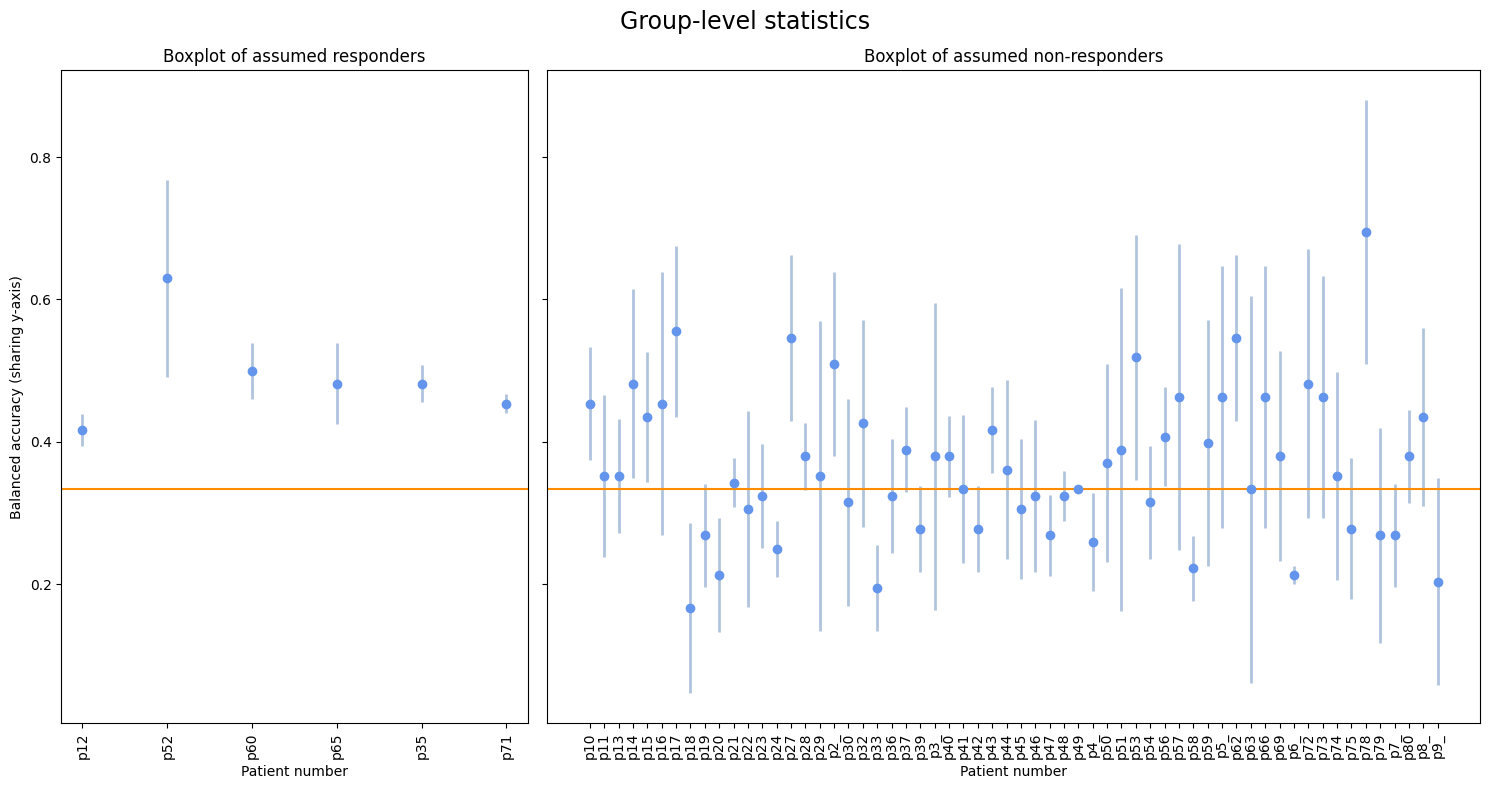

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8), gridspec_kw={'width_ratios':[1,2]})

means_r = []
std_r = []

means_nr = []
std_nr = []
for i in responders:
    means_r.append(i[0])
    std_r.append(i[1])

for j in non_responders:
    means_nr.append(j[0])
    std_nr.append(j[1])

ax1.errorbar(x=range(len(responders)), y=means_r, yerr=std_r, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')
ax2.errorbar(x=range(len(non_responders)), y=means_nr, yerr=std_nr, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')
ax1.axhline(1/3, c='darkorange')
ax2.axhline(1/3, c='darkorange')
ax1.set_title('Boxplot of assumed responders')
ax2.set_title('Boxplot of assumed non-responders')
ax1.set_ylabel('Balanced accuracy (sharing y-axis)')
ax1.set_xlabel('Patient number')
ax2.set_xlabel('Patient number')
ax1.set_xticks(range(len(B)), [patient_numbers[i] for i in B], rotation=90)
ax2.set_xticks(range(len(all_data)-len(B)), [patient_numbers[i] for i in range(len(all_data)) if i not in B], rotation=90)
fig.suptitle('Group-level statistics', fontsize='17')
plt.tight_layout()
plt.show()

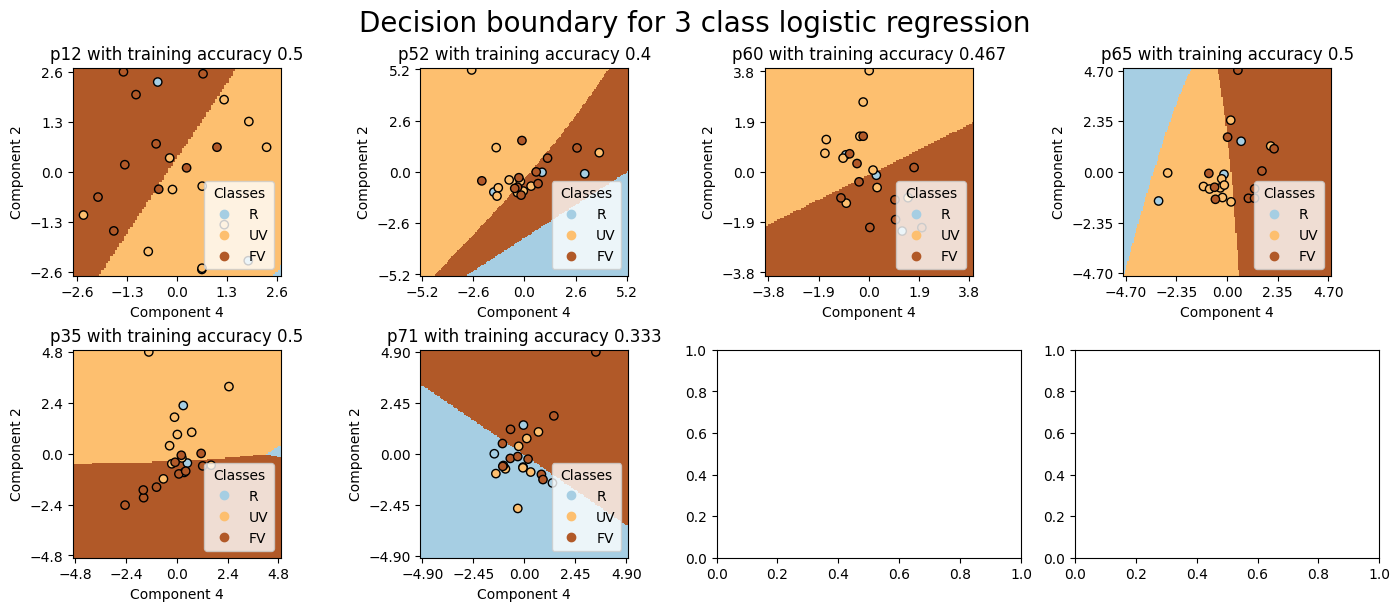

In [123]:
#three-class
#good plots
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])
from sklearn.metrics import balanced_accuracy_score


people_r = list(B)

fig, axes = plt.subplots(2,4, figsize=(14,6), constrained_layout=True)
fig.suptitle('Decision boundary for 3 class logistic regression', fontsize=20)

components_n = components.shape[0]
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)


for i,ax in zip(range(len(people_r)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    #train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    train_y2 = y1
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)

    train_X = pd.DataFrame(train_X[:,best_comp[0:2]], columns=best_comp[0:2])
    #print(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    #print(len(y1), len(train_X[first_feature]))
    names = ['R', 'UV', 'FV']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
   
    score1 = balanced_accuracy_score(train_y2, predictions)
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(best_comp[0])
    ylabel = 'Component ' + str(best_comp[1])
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X.iloc[:,[0,1]],grid_resolution=600,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_aspect('equal')
    #disp.ax_.set_xlim(-3,3)
    #disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )
    color = 'k'
    title = str(patient_numbers[people_r[i]]) + ' with training accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)

plt.show()

## Cross validation choosing only 2 features

In [11]:
first_feature = np.argmax(feat_scores)

Finding second optimal PCA component to choose

In [12]:

t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)
feat_scores_r2 = np.zeros(components_n)
all_scores = np.empty((len(all_data), components_n, 3))

for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())

    for j in range(components_n):
        if j != first_feature:

            skf = StratifiedKFold(n_splits=3)

            scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,[first_feature,j]]), np.array(train_y), cv = skf, scoring='balanced_accuracy')
            score = scores.sum()
            feat_scores_r2[j] += score
            all_scores[i,j,:] = scores

In [15]:
feat_scores_r2

array([69.91666667, 69.08333333, 69.97222222, 69.63888889,  0.        ,
       67.27777778, 69.91666667, 66.72222222, 66.97222222, 67.80555556,
       68.94444444, 68.75      , 67.63888889, 65.69444444])

In [13]:
second_feature = np.argmax(feat_scores_r2) 

In [14]:
print('Chosen features are: ', first_feature, ',', second_feature)

sort1 = np.argsort(abs(np.array(components[first_feature])))[::-1]
sort2 = np.argsort(abs(np.array(components[second_feature])))[::-1]
#print([(components[0][i], m_list[i]) for i in range(25)])
#print(components[0])
print([(m_list[j], components[first_feature][j]) for j in sort1[0:5]])
print([(m_list[j], components[second_feature][j]) for j in sort2[0:5]])

Chosen features are:  4 , 2
[('Theta', 0.3872639377954475), ('Delta', 0.3788883573381827), ('Gamma', 0.37464502828227364), ('Beta', 0.3735286719054915), ('MeanHR', -0.29568736468523554)]
[('StdHR', 0.5483966322966676), ('StdRR', 0.4971895787714632), ('MaxHR', 0.4872906596614765), ('MinHR', -0.21992900490084422), ('Theta', 0.21049747625445903)]


Plot of feature importances

T-test

In [15]:
B = set()

for count, i in enumerate(all_scores):
    scores = i[second_feature]
    t_value = (np.mean(scores) - 1/3) / (np.std(scores) / np.sqrt(3))

    #if np.isclose(t_scipy, t_value):
    #    count += 1
    result = scipy.stats.ttest_1samp(scores, popmean=1/3, alternative='greater')
    t_scipy = result.statistic
    if result.pvalue <= 0.05:
        #print('hurra person: ',i,j, 'has score: ', scores)
        B.add(count)
    #if t_value > 2.920: # critical value
    #    B.add(i)
    

C:\Users\CHVI0030\AppData\Local\Temp\ipykernel_17556\1287038147.py:5: RuntimeWarning: invalid value encountered in scalar divide
  t_value = (np.mean(scores) - 1/3) / (np.std(scores) / np.sqrt(3))
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [16]:
#print('First set of persons with significantly higher accuracy than 0.33', sorted(A), len(A))
print('Second set of persons with significantly higher accuracy than 0.33', sorted(B), len(B))

# union 
#print("Union :", sorted(A | B), len(A | B)) 
  
# intersection 
#print("Intersection :", sorted(A & B), len(A & B)) 
  
# difference 
#print("Difference first-second round:", sorted(A - B), len(A - B)) 
#print("Difference second-first round:", sorted(B - A), len(B - A)) 

persons_from_cross_val = [patient_numbers[i] for i in sorted(B)]
print(persons_from_cross_val)

Second set of persons with significantly higher accuracy than 0.33 [4, 14, 20, 22, 46, 48] 6
['p14', 'p24', 'p32', 'p35', 'p59', 'p60']


Boxplots for CV accuracies (after 2. step, thereby with 2 components)

In [17]:
cv_scores = all_scores[:,second_feature,:]
responders = []
non_responders = []

for i in range(len(all_data)):
    if i in B:
        responders.append([np.mean(cv_scores[i,:]), np.std(cv_scores[i,:])])
    else:
        non_responders.append([np.mean(cv_scores[i,:]), np.std(cv_scores[i,:])])

# Group sizes
print('Number of responders: ', len(responders))
print('Number of non-responders: ', len(non_responders))

Number of responders:  6
Number of non-responders:  60


60 60
6 6


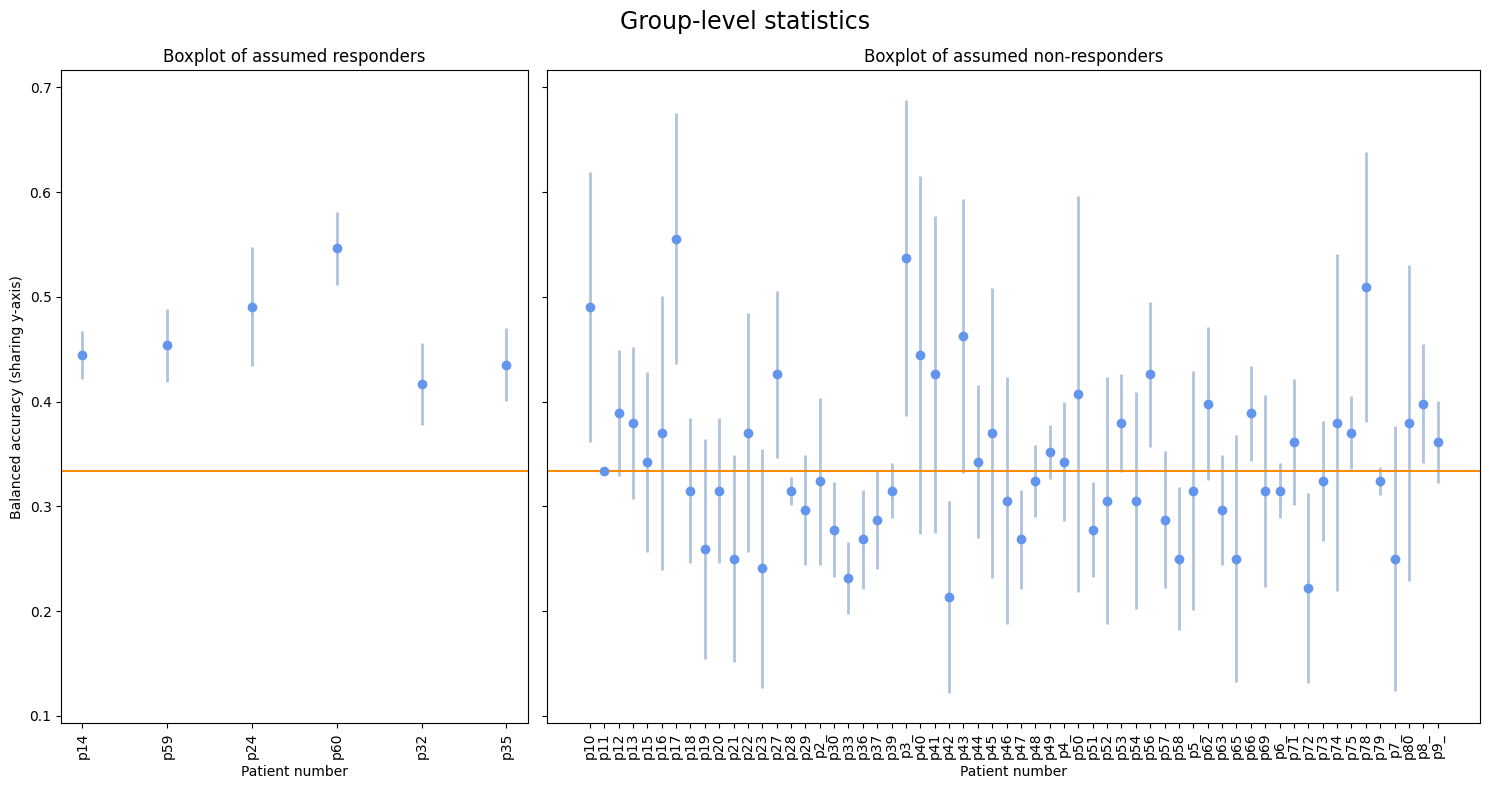

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8), gridspec_kw={'width_ratios':[1,2]})

means_r = []
std_r = []

means_nr = []
std_nr = []
for i in responders:
    means_r.append(i[0])
    std_r.append(i[1])

for j in non_responders:
    means_nr.append(j[0])
    std_nr.append(j[1])

print(len(means_nr), len(std_nr))
print(len(means_r), len(std_r))

ax1.errorbar(x=range(len(responders)), y=means_r, yerr=std_r, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')
ax2.errorbar(x=range(len(non_responders)), y=means_nr, yerr=std_nr, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')
ax1.axhline(1/3, c='darkorange')
ax2.axhline(1/3, c='darkorange')
ax1.set_title('Boxplot of assumed responders')
ax2.set_title('Boxplot of assumed non-responders')
ax1.set_ylabel('Balanced accuracy (sharing y-axis)')
ax1.set_xlabel('Patient number')
ax2.set_xlabel('Patient number')
ax1.set_xticks(range(len(B)), [patient_numbers[i] for i in B], rotation=90)
ax2.set_xticks(range(len(all_data)-len(B)), [patient_numbers[i] for i in range(len(all_data)) if i not in B], rotation=90)
fig.suptitle('Group-level statistics', fontsize='17')
plt.tight_layout()
plt.show()

## Decision boundaries

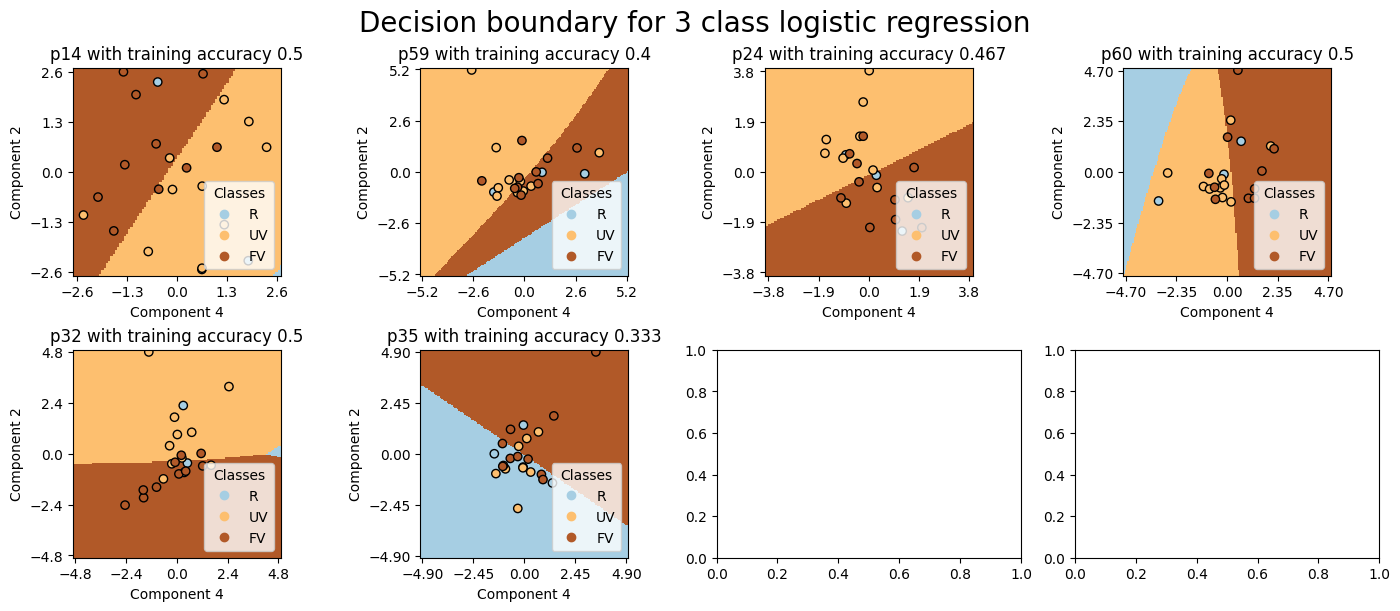

In [19]:
#three-class
#good plots
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])
from sklearn.metrics import balanced_accuracy_score


people_r = list(B)

fig, axes = plt.subplots(2,4, figsize=(14,6), constrained_layout=True)
fig.suptitle('Decision boundary for 3 class logistic regression', fontsize=20)

components_n = components.shape[0]
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)


for i,ax in zip(range(len(people_r)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    #train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    train_y2 = y1
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)

    train_X = pd.DataFrame(train_X[:,[first_feature, second_feature]], columns=[first_feature, second_feature])
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    #print(len(y1), len(train_X[first_feature]))
    names = ['R', 'UV', 'FV']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
   
    score1 = balanced_accuracy_score(train_y2, predictions)
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=600,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_aspect('equal')
    #disp.ax_.set_xlim(-3,3)
    #disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )
    color = 'k'
    title = str(patient_numbers[people_r[i]]) + ' with training accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)

plt.show()

In [20]:
# Finding non-responders to plot
people_nr = []

for i in range(len(all_data)):
    if i not in people_r:
        people_nr.append(i)

In [21]:
# Choosing 8 non-responders (randomly)
import random

chosen_bads = random.choices(people_nr, k=8)
print('Chosen non-responders (index): ', chosen_bads)

nr_list = [patient_numbers[i] for i in chosen_bads]
print(nr_list)

Chosen non-responders (index):  [15, 63, 8, 47, 6, 16, 65, 13]
['p27', 'p80', 'p18', 'p5_', 'p16', 'p28', 'p9_', 'p23']


c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python3

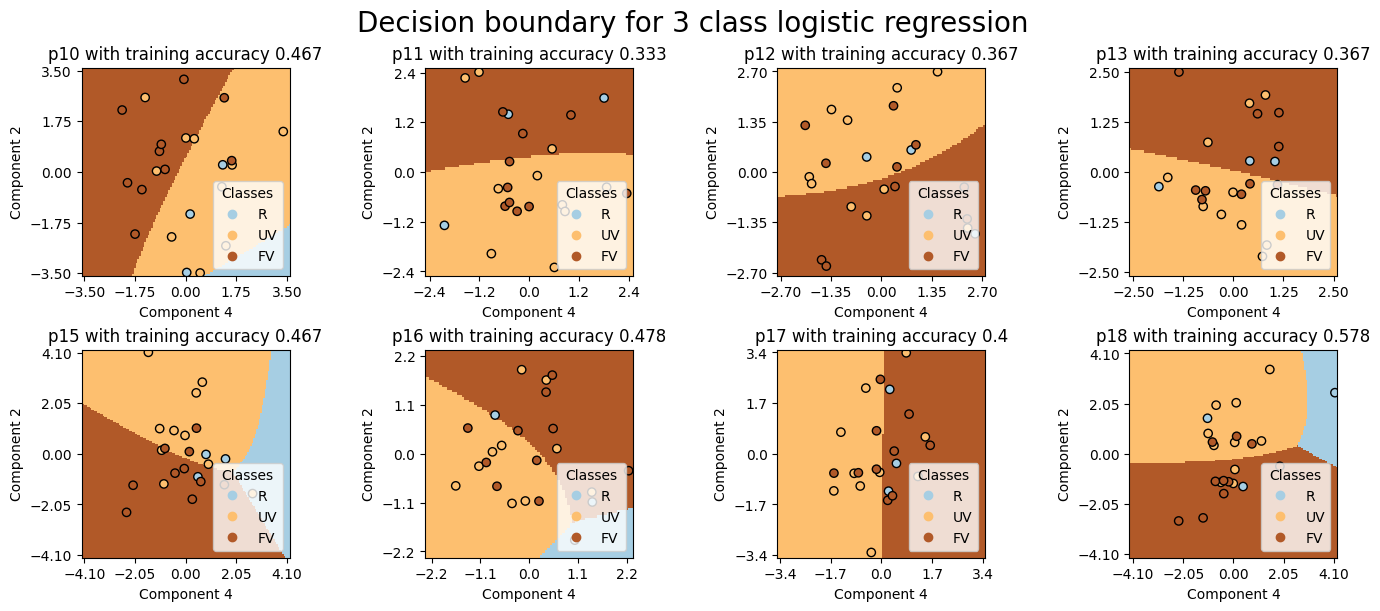

In [23]:
# BAD DECISION BOUNDARIES

fig, axes = plt.subplots(2,4, figsize=(14,6), constrained_layout=True)
fig.suptitle('Decision boundary for 3 class logistic regression', fontsize=20)

components_n = components.shape[0]
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

people_r = people_nr

for i,ax in zip(range(len(people_r)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    #train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    train_y2 = y1
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)

    train_X = pd.DataFrame(train_X[:,[first_feature, second_feature]], columns=[first_feature, second_feature])
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    #print(len(y1), len(train_X[first_feature]))
    names = ['R', 'UV', 'FV']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
   
    score1 = balanced_accuracy_score(train_y2, predictions)
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=600,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_aspect('equal')
    #disp.ax_.set_xlim(-3,3)
    #disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )
    color = 'k'
    title = str(patient_numbers[people_r[i]]) + ' with training accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)

plt.show()

# Clustering begin

In [143]:
r_data = []
m_data = []
f_data = []
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]

for data in all_data:
    R_indicesToKeep = data['Event'] == 'R'
    df_r = data.loc[R_indicesToKeep]

    M_indicesToKeep = data['Event'] == 'M'
    df_m = data.loc[M_indicesToKeep]

    F_indicesToKeep = data['Event'] == 'F'
    df_f = data.loc[F_indicesToKeep]

    r_mean = pd.DataFrame(df_r[m_list].mean(axis=0)).transpose()
    m_mean = pd.DataFrame(df_m[m_list].mean(axis=0)).transpose()
    f_mean = pd.DataFrame(df_f[m_list].mean(axis=0)).transpose()

    r_mean.columns = mean_list
    m_mean.columns = mean_list
    f_mean.columns = mean_list

    r_std = pd.DataFrame(df_r[m_list].std(axis=0)).transpose()
    m_std = pd.DataFrame(df_m[m_list].std(axis=0)).transpose()
    f_std = pd.DataFrame(df_f[m_list].std(axis=0)).transpose()
        
    r_std.columns = std_list
    m_std.columns = std_list
    f_std.columns = std_list
    
    rest = pd.concat([r_mean,r_std],axis=1).to_numpy()
    med = pd.concat([m_mean,m_std],axis=1).to_numpy()
    fam = pd.concat([f_mean,f_std],axis=1).to_numpy()

    r_data.append(rest[0])
    m_data.append(med[0])
    f_data.append(fam[0])

In [144]:
X = [f_data[i] - r_data[i] for i in range(len(r_data))] + [m_data[i] - r_data[i] for i in range(len(r_data))]
y = [i for i in range(0,len(r_data))] + [i for i in range(0,len(r_data))]


### pca transform data

In [145]:
warnings.filterwarnings(action='ignore', category=UserWarning)
X_pca = [np.append(pca.transform(X[i][0:25].reshape(1,-1)),pca.transform(X[i][25:].reshape(1,-1))) for i in range(len(X))]

In [146]:
X_pca_array = np.asarray(X_pca)
print(X_pca_array.shape)

(132, 28)


### take chosen components from data and fit clustering algorithms

In [147]:
b= mean_list+std_list
min_size = 5
chosen_features = best_comp
ind = [True if i in chosen_features else False for i in range(components_n)] + [True if i in chosen_features else False for i in range(components_n)]
X_pca_chosen = X_pca_array[:,ind]   
    
sclustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_pca_chosen)
sy_pred = sclustering.labels_

hdb = HDBSCAN(min_cluster_size=min_size).fit(X_pca_chosen)
hy_pred = hdb.labels_
patient_numbers2 = patient_numbers+patient_numbers

dclustering = DBSCAN(min_samples=min_size).fit(X_pca_chosen)
dy_pred = dclustering.labels_    

oclustering = OPTICS(min_samples=min_size).fit(X_pca_chosen)
oy_pred = oclustering.labels_

Plotting dendogram for HDBSCAN

In [148]:
import scipy.cluster.hierarchy as spc
#import hdbscan
#clust = hdbscan.HDBSCAN(min_cluster_size=5).fit(X_pca_chosen)
df = pd.DataFrame(hy_pred)

#pdist = spc.distance.pdist(df)
linkage = spc.linkage(df, method='ward', metric='euclidean')
idx = spc.fcluster(linkage, t=3, criterion='maxclust')


In [149]:
linkage.shape

(131, 4)

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245]),
 [Text(5, 0, '131'),
  Text(15, 0, '130'),
  Text(25, 0, '129'),
  Text(35, 0, '128'),
  Text(45, 0, '127'),
  Text(55, 0, '126'),
  Text(65, 0, '125'),
  Text(75, 0, '124'),
  Text(85, 0, '123'),
  Text(95, 0, '122'),
  Text(105, 0, '121'),
  Text(115, 0, '120'),
  Text(125, 0, '119'),
  Text(135, 0, '118'),
  Text(145, 0, '117'),
  Text(155, 0, '116'),
  Text(165, 0, '115'),
  Text(175, 0, '114'),
  Text(185, 0, '113'),
  Text(195, 0, '112'),
  Text(205, 0, '111'),
  Text(215, 0, '110'),
  Text(225, 0, '(96)'),
  Text(235, 0, '(6)'),
  Text(245, 0, '(8)')])

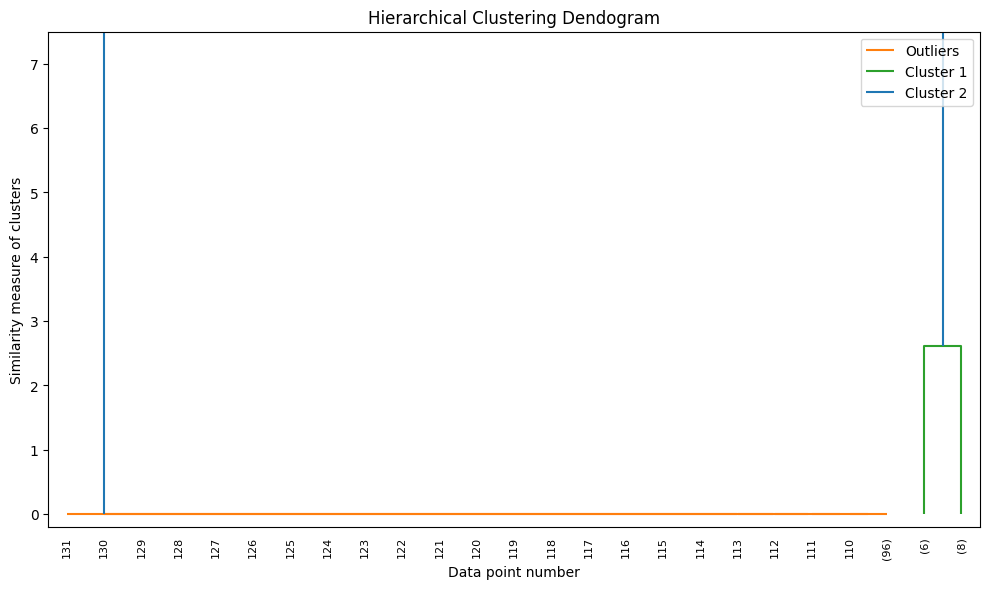

In [150]:
fig = plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendogram')
dn = spc.dendrogram(linkage, leaf_font_size=8, truncate_mode='lastp', p=25)
plt.legend(['Outliers', 'Cluster 1', 'Cluster 2'])
plt.xlabel('Data point number')
plt.ylabel('Similarity measure of clusters')
plt.ylim(-0.2,7.5)
plt.tight_layout()
plt.xticks(rotation=90)


In [42]:
den = np.array(dn['color_list'])

count = np.unique(den, return_counts=True)
print(count)

(array(['C0', 'C1', 'C2'], dtype='<U2'), array([ 1, 21,  2], dtype=int64))


### plot clustering

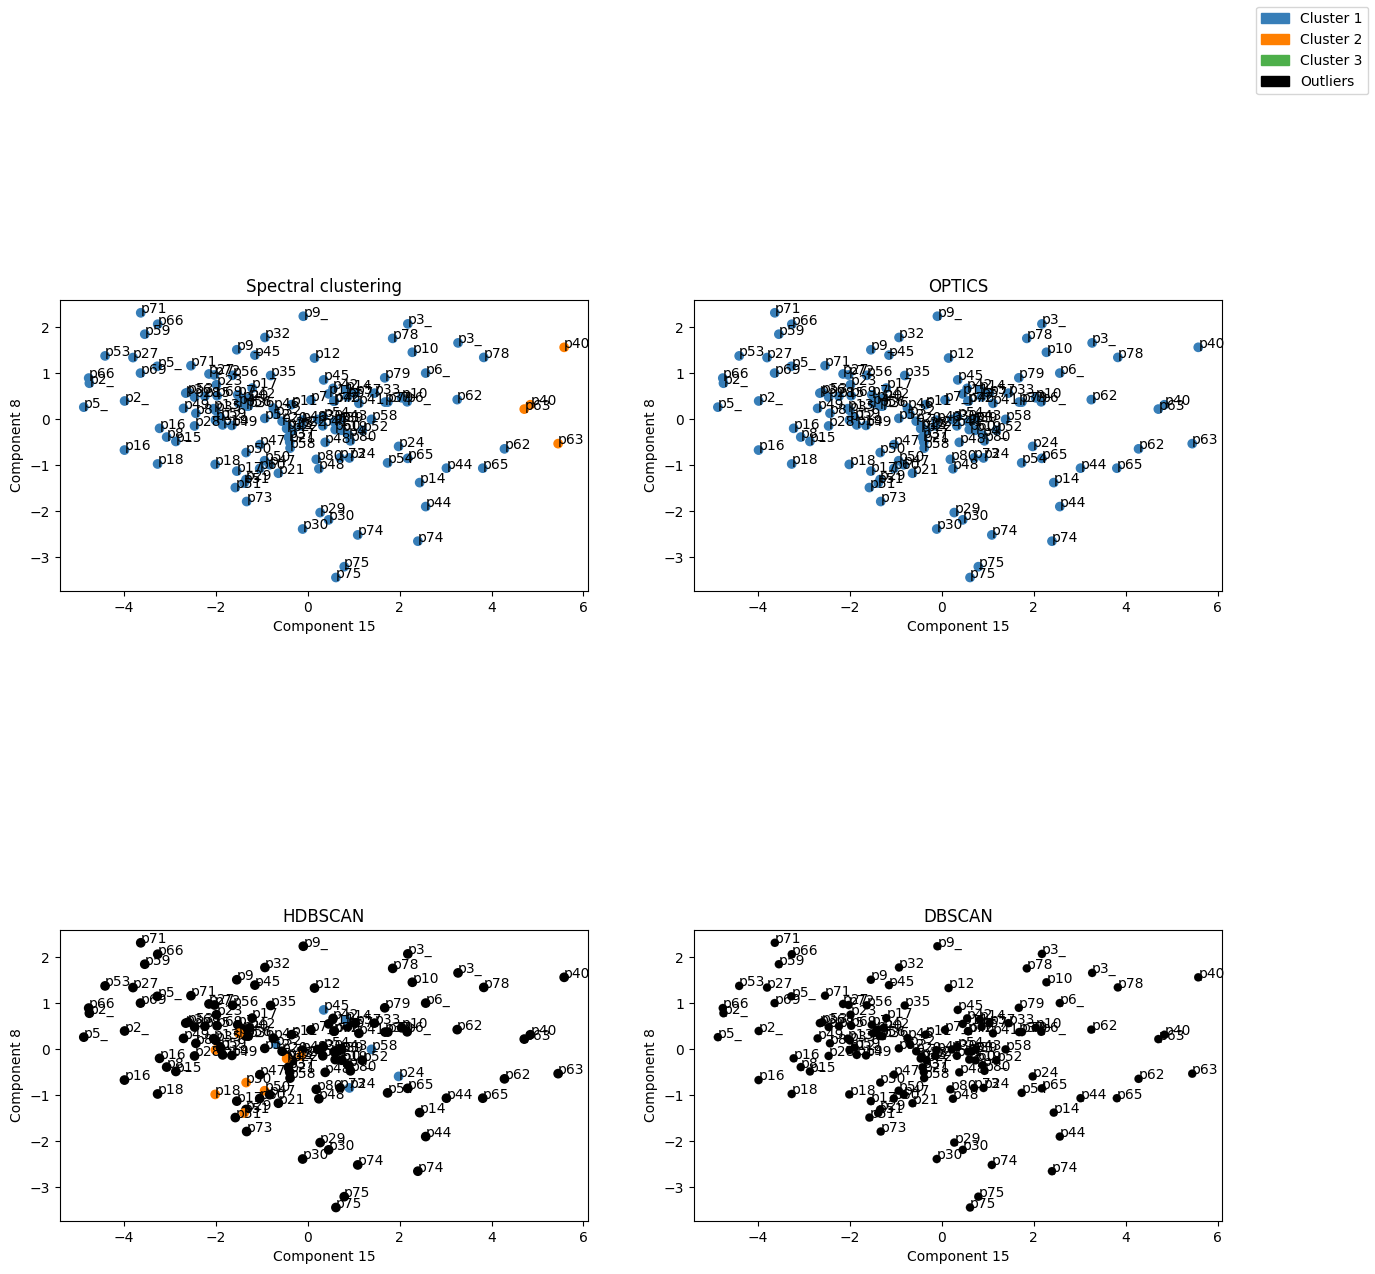

In [151]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a", 
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                ]
            ),
            int(max(np.concatenate((dy_pred, hy_pred, oy_pred, sy_pred)))+1),
        )
    )
)

# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
ax[0,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[sy_pred])
for i, txt in enumerate(y):
    ax[0,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[0,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,0].set_title('Spectral clustering')
ax[0,0].set_xlabel('Component 15')
ax[0,0].set_ylabel('Component 8')

ax[0,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[oy_pred])
for i, txt in enumerate(y):
    ax[0,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[0,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,1].set_title('OPTICS')
#ax[0,1].legend()
ax[0,1].set_xlabel('Component 15')
ax[0,1].set_ylabel('Component 8')

ax[1,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[hy_pred])
for i, txt in enumerate(y):
    ax[1,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[1,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,0].set_title('HDBSCAN')
#ax[1,0].legend()
ax[1,0].set_xlabel('Component 15')
ax[1,0].set_ylabel('Component 8')

ax[1,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[dy_pred], linewidth = 0.1)
for i, txt in enumerate(y):
    ax[1,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[1,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,1].set_title('DBSCAN')
ax[1,1].set_xlabel('Component 15')
ax[1,1].set_ylabel('Component 8')
#ax[1,1].legend()
pop_a = mpatches.Patch(color="#377eb8", label='Cluster 1') 
pop_b = mpatches.Patch(color="#ff7f00", label='Cluster 2')
pop_d = mpatches.Patch(color="#4daf4a", label='Cluster 3')
pop_c = mpatches.Patch(color="#000000", label='Outliers')
fig.legend(handles=[pop_a,pop_b,pop_d,pop_c]) 

### find different cluster groups

In [152]:
#adding wether it is familiar-resting or unfamiliar-resting datapoint
patient_numbers_with_event = [patient_num +'-fr' for patient_num in patient_numbers] + [patient_num +'-mr' for patient_num in patient_numbers] 

In [153]:
#finding each label for each patient
sy_groups = [(sy_pred[i], patient_numbers_with_event[i]) for i in range(len(sy_pred))]
oy_groups = [(oy_pred[i], patient_numbers_with_event[i]) for i in range(len(oy_pred))]
hy_groups = [(hy_pred[i], patient_numbers_with_event[i]) for i in range(len(hy_pred))]
dy_groups = [(dy_pred[i], patient_numbers_with_event[i]) for i in range(len(dy_pred))]

In [154]:
#cluster sizes
sy_groups_counts = list(zip(*np.unique(sy_pred, return_counts=True)))
oy_groups_counts = list(zip(*np.unique(oy_pred, return_counts=True)))
hy_groups_counts = list(zip(*np.unique(hy_pred, return_counts=True)))
dy_groups_counts = list(zip(*np.unique(dy_pred, return_counts=True)))
print(sy_groups_counts)
print(oy_groups_counts)
print(hy_groups_counts)
print(dy_groups_counts)

[(0, 128), (1, 4)]
[(0, 132)]
[(-1, 118), (0, 6), (1, 8)]
[(-1, 132)]


In [66]:
#cluster sorted
sort_sy = sorted(sy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_oy = sorted(oy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_hy = sorted(hy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_dy = sorted(dy_groups, key = lambda x: (x[0],x[1]))[::-1]
print(sort_sy)
print(sort_oy)
print(sort_hy)
print(sort_dy)

[(1, 'p8_-mr'), (1, 'p8_-fr'), (1, 'p7_-mr'), (1, 'p7_-fr'), (1, 'p78-mr'), (1, 'p78-fr'), (1, 'p74-fr'), (1, 'p69-mr'), (1, 'p68-mr'), (1, 'p68-fr'), (1, 'p66-fr'), (1, 'p65-mr'), (1, 'p62-mr'), (1, 'p62-fr'), (1, 'p61-mr'), (1, 'p61-fr'), (1, 'p60-mr'), (1, 'p5_-mr'), (1, 'p5_-fr'), (1, 'p58-fr'), (1, 'p54-fr'), (1, 'p53-mr'), (1, 'p53-fr'), (1, 'p52-fr'), (1, 'p51-fr'), (1, 'p50-mr'), (1, 'p50-fr'), (1, 'p4_-mr'), (1, 'p48-mr'), (1, 'p47-mr'), (1, 'p47-fr'), (1, 'p46-mr'), (1, 'p46-fr'), (1, 'p42-fr'), (1, 'p41-mr'), (1, 'p41-fr'), (1, 'p40-mr'), (1, 'p40-fr'), (1, 'p3_-fr'), (1, 'p39-fr'), (1, 'p38-mr'), (1, 'p38-fr'), (1, 'p35-mr'), (1, 'p35-fr'), (1, 'p33-mr'), (1, 'p33-fr'), (1, 'p32-mr'), (1, 'p32-fr'), (1, 'p31-mr'), (1, 'p31-fr'), (1, 'p2_-mr'), (1, 'p2_-fr'), (1, 'p29-mr'), (1, 'p29-fr'), (1, 'p28-mr'), (1, 'p28-fr'), (1, 'p27-mr'), (1, 'p25-mr'), (1, 'p25-fr'), (1, 'p23-mr'), (1, 'p22-mr'), (1, 'p22-fr'), (1, 'p21-mr'), (1, 'p21-fr'), (1, 'p20-mr'), (1, 'p20-fr'), (1, 'p19-

### plot patients that are outliers/in smaller group from dbscan

In [67]:
outliers_dy = [(-1, 'p9_-mr'), (-1, 'p8_-mr'), (-1, 'p80-mr'), (-1, 'p80-fr'), (-1, 'p7_-mr'), (-1, 'p7_-fr'), (-1, 'p79-mr'), (-1, 'p79-fr'), (-1, 'p78-mr'), (-1, 'p78-fr'), (-1, 'p73-mr'), (-1, 'p67-mr'), (-1, 'p67-fr'), (-1, 'p66-mr'), (-1, 'p63-mr'), (-1, 'p63-fr'), (-1, 'p62-fr'), (-1, 'p61-fr'), (-1, 'p60-mr'), (-1, 'p60-fr'), (-1, 'p5_-fr'), (-1, 'p58-mr'), (-1, 'p58-fr'), (-1, 'p57-mr'), (-1, 'p57-fr'), (-1, 'p56-mr'), (-1, 'p56-fr'), (-1, 'p54-mr'), (-1, 'p53-fr'), (-1, 'p52-mr'), (-1, 'p51-fr'), (-1, 'p49-mr'), (-1, 'p49-fr'), (-1, 'p48-mr'), (-1, 'p46-mr'), (-1, 'p46-fr'), (-1, 'p44-mr'), (-1, 'p44-fr'), (-1, 'p41-mr'), (-1, 'p40-mr'), (-1, 'p3_-mr'), (-1, 'p3_-fr'), (-1, 'p35-fr'), (-1, 'p34-mr'), (-1, 'p34-fr'), (-1, 'p33-mr'), (-1, 'p32-mr'), (-1, 'p32-fr'), (-1, 'p31-mr'), (-1, 'p31-fr'), (-1, 'p30-mr'), (-1, 'p30-fr'), (-1, 'p28-fr'), (-1, 'p27-mr'), (-1, 'p27-fr'), (-1, 'p22-mr'), (-1, 'p22-fr'), (-1, 'p21-mr'), (-1, 'p21-fr'), (-1, 'p20-mr'), (-1, 'p20-fr'), (-1, 'p19-mr'), (-1, 'p19-fr'), (-1, 'p18-fr'), (-1, 'p17-mr'), (-1, 'p17-fr'), (-1, 'p16-fr'), (-1, 'p15-fr'), (-1, 'p14-fr'), (-1, 'p12-fr'), (-1, 'p10-mr'), (-1, 'p10-fr')]
patient_data_pca = []
patients_in_group = []
patients_in_group_counts = []
for _, patient in outliers_dy:
    patient = patient[:3]
    patients_in_group_counts.append(patient)
    if patient not in patients_in_group:
        patients_in_group.append(patient)
        patient_ind = patient_numbers.index(patient)
        train_X = all_data[patient_ind][m_list]
        train_X = pca.transform(train_X)
        train_X = pd.DataFrame(train_X)
        patient_data_pca.append(train_X)

patients_in_group_counts = list(zip(*np.unique(patients_in_group_counts, return_counts=True)))
sort_p_counts = sorted(patients_in_group_counts, key = lambda x: x[1])[::-1]
print(sort_p_counts)


[('p80', 2), ('p7_', 2), ('p79', 2), ('p78', 2), ('p67', 2), ('p63', 2), ('p60', 2), ('p58', 2), ('p57', 2), ('p56', 2), ('p49', 2), ('p46', 2), ('p44', 2), ('p3_', 2), ('p34', 2), ('p32', 2), ('p31', 2), ('p30', 2), ('p27', 2), ('p22', 2), ('p21', 2), ('p20', 2), ('p19', 2), ('p17', 2), ('p10', 2), ('p9_', 1), ('p8_', 1), ('p73', 1), ('p66', 1), ('p62', 1), ('p61', 1), ('p5_', 1), ('p54', 1), ('p53', 1), ('p52', 1), ('p51', 1), ('p48', 1), ('p41', 1), ('p40', 1), ('p35', 1), ('p33', 1), ('p28', 1), ('p18', 1), ('p16', 1), ('p15', 1), ('p14', 1), ('p12', 1)]


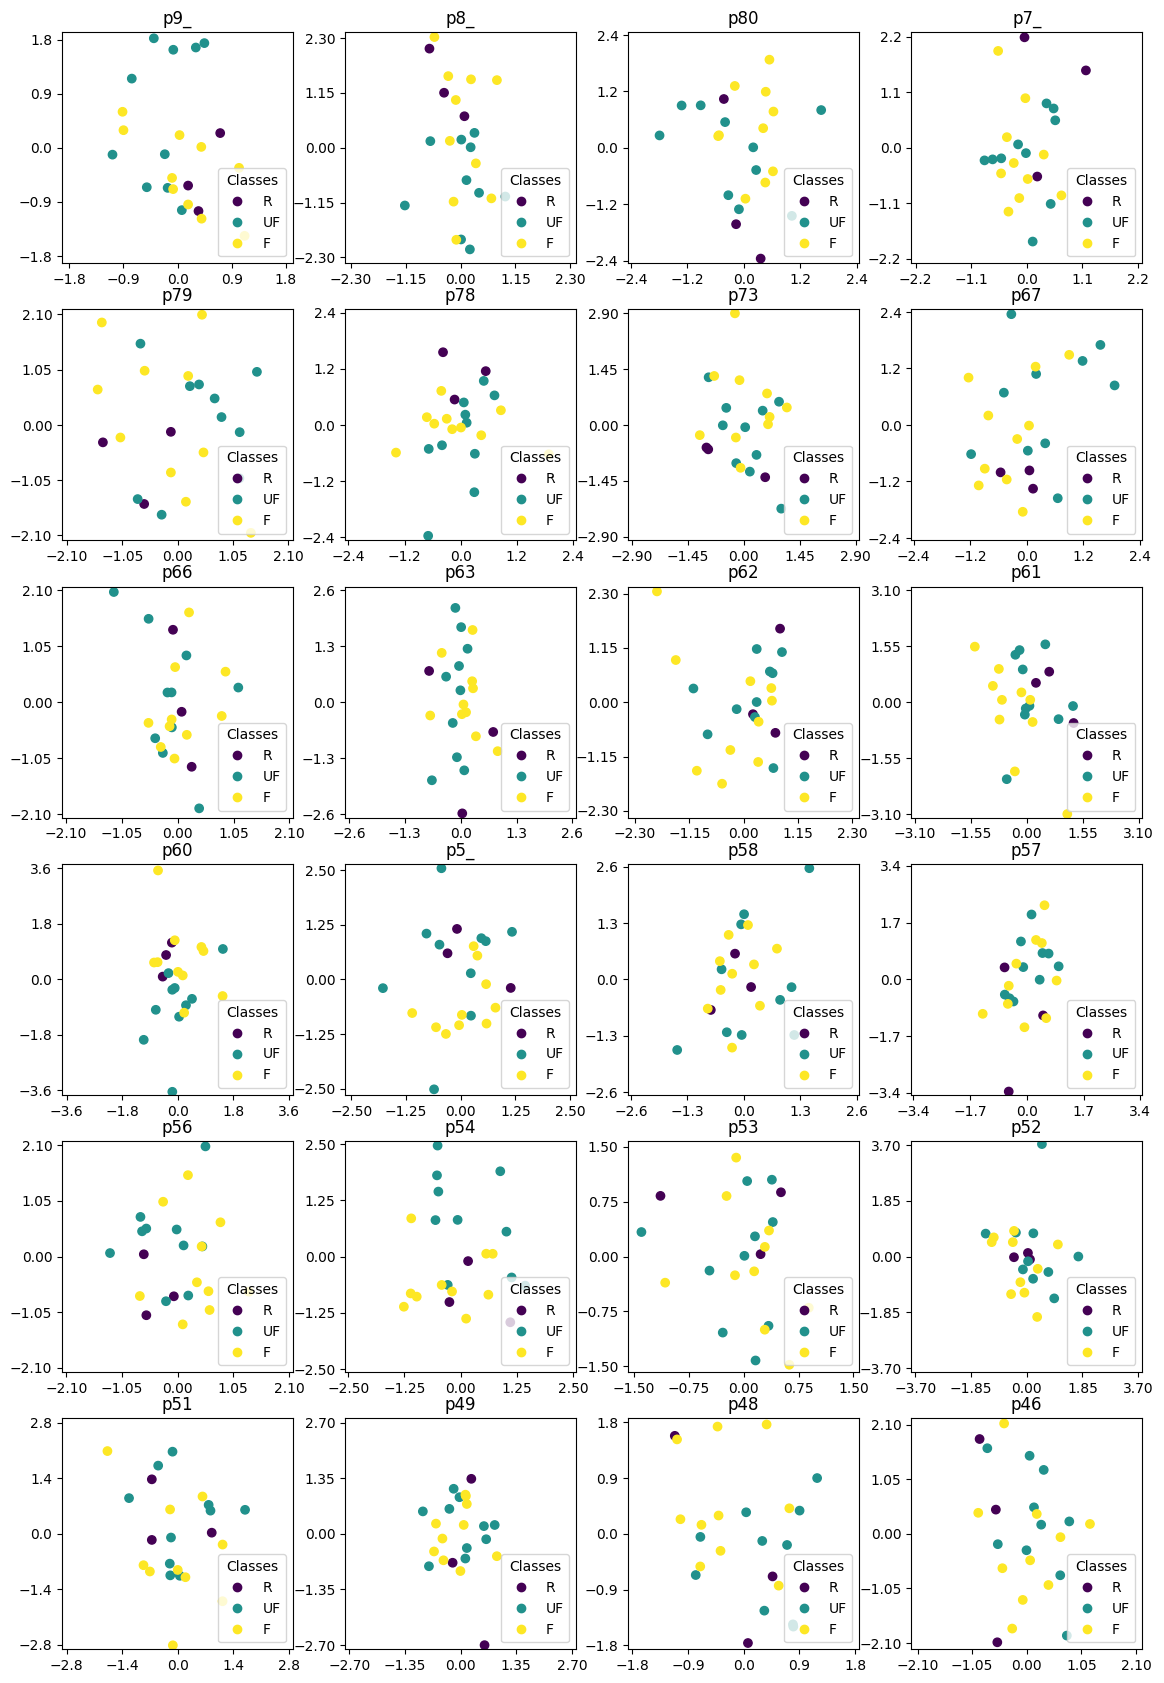

In [93]:
fig, axes = plt.subplots(6,4, figsize=(14,21))
for i,ax in zip(range(len(patients_in_group)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)

    scatter = ax.scatter(patient_data_pca[i][first_feature], patient_data_pca[i][second_feature], c=y1)
    max_val = np.max(np.append(abs(patient_data_pca[i][first_feature]),abs(patient_data_pca[i][second_feature]))) 
    ax.set_ylim(-max_val-0.1,max_val+0.1)
    ax.set_xlim(-max_val-0.1,max_val+0.1)
    ax.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    ax.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])

    ax.set_aspect('equal', adjustable=None, anchor=None, share=False)
    ax.legend(
        scatter.legend_elements()[0],s
        ['R', 'UF', 'F'],
        title="Classes",
        loc = 'lower right'
    )
    ax.set_title(patients_in_group[i])

